# Analysis Tool

#### Use Deploy_GR_Global_Test to test unverified models for global growth rates
###### Be sure to establish paths where models are stored & where settled models should be stored

#### 

In [1]:
# Import Python Libraries
import numpy as np
import jax      # PIP JAX install - Search for the windows [cpu] version
import jaxlib
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpyro
import numpyro.distributions as dist
from pathlib import Path
import scipy.stats as stats
import shutil
import re

In [2]:
# Figure Parameters Reset to default
def fig_reset():
    style.use('default')  # Clear any custom styles that might have been applied
    plt.close('all')  # Clear any active figures
    plt.set_cmap('viridis')  # Reset default colormaps
    plt.rcParams.update(plt.rcParamsDefault)  # Clear any manually set default figure or axes properties
    plt.ioff()  # Reset interactive mode
    mpl.rcdefaults()  # Reset all rcParams to default values
    mpl.rcParams.update(mpl.rcParamsDefault)  # Additional resets for completeness

fig_reset() # Reset MATPLOTLIB parameters to default

# Colors
color_in = 'red'
color_mid = 'green'
color_out = 'blue'
color_by_num = ['crimson', 'orange', 'goldenrod', 'green', 'skyblue', 'darkorchid']
simple_color = ['red', 'orange', 'yellow', 'green', 'blue', 'orchid']

# Color pallette
α = .5
ß = 0.25
line_width = 1.5
full_line_sty = [':', '--', '-', '-.']
full_marker_pal = ['o','x','^','s','P','H','*']
full_color_pal = ['red', 'orange', 'gold', 'green', 'b', 'darkorchid', 'chocolate', 'deeppink', 'cyan', 'darkcyan', 'black']
full_color_pal_disk = ['dimgrey', 'b', 'limegreen', 'firebrick', 'gold', 'orchid', 'chocolate', 'deeppink', 'cyan', 'darkcyan', 'black']


<Figure size 640x480 with 0 Axes>

#### Model Details Imports

Can be used to import a single model by using {variant}_Import

Can target all settled models using Deploy_{variant}_Import

###### Recommend using Fort_50 as polyout has an error when logging the boundaries for the star and torus

In [3]:
# Single - Fort.50 import - Pandas Dataframe
def Fort_50_Import(target_folder, Transpose):
    # Import Fort.50 data
    colnames=['col1', 'col2', 'col3', 'col4']
    data_raw = pd.read_csv(target_folder / "fort.50", names=colnames, header=None, sep='\s+')
    
    # Function to remove colons from string values
    def remove_colon(x):
        if isinstance(x, str):
            return x.replace(':', '')
        else:
            return x
    # Remove colons from the first & thrid columns
    data_raw[colnames[0]] = data_raw[colnames[0]].apply(lambda x: remove_colon(x) if isinstance(x, str) else x)
    data_raw[colnames[2]] = data_raw[colnames[2]].apply(lambda x: remove_colon(x) if isinstance(x, str) else x)
    # Clean up row 70 & 71 data name compressed into col1, shifting data into col2
    data_raw.loc[70,colnames[0]] = 'drho_min/ro'
    data_raw.loc[71,colnames[0]] = 'W_min/ro'
    data_raw.loc[70,colnames[1]] = data_raw.loc[70,colnames[2]]
    data_raw.loc[71,colnames[1]] = data_raw.loc[71,colnames[2]]
    # Fix entry 72
    row_72_key = data_raw.loc[72, colnames[2]]
    row_72_value = data_raw.loc[72, colnames[3]]
    # new row of data
    new_data_72 = {colnames[0]: [row_72_key],
                colnames[1]: [row_72_value]}
    # turn new row data into a dataframe
    new_row_72 = pd.DataFrame(new_data_72)
    # concatenate the new dataframe to the data set
    data_raw = pd.concat([data_raw, new_row_72], ignore_index=True)
    # Fix jin,jout to individual entries, concat to dataframe
    data_jd_in_value = data_raw.loc[4, colnames[1]]
    data_jd_out_value = data_raw.loc[4, colnames[2]]
    # new row of data
    new_data_jd_in = {colnames[0]: ['jd_in'],
                colnames[1]: [data_jd_in_value]}
    new_data_jd_out = {colnames[0]: ['jd_out'],
                colnames[1]: [data_jd_out_value]}
    # turn new row data into a dataframe
    new_row_jd_in = pd.DataFrame(new_data_jd_in)
    # concatenate the new dataframe to the data set
    data_raw = pd.concat([data_raw, new_row_jd_in], ignore_index=True)
    # Repeat for jd_out
    new_row_jd_out = pd.DataFrame(new_data_jd_out)
    data_raw = pd.concat([data_raw, new_row_jd_out], ignore_index=True)
    # Fix jstar,kstar overwriting jd_in,jd_out tuble in line 4
    data_raw.loc[3,colnames[0]] = 'jstar'
    data_raw.loc[4,colnames[0]] = 'kstar'
    data_raw.loc[4,colnames[1]] = data_raw.loc[3,colnames[2]]
    # Delete extra columns of data
    data_raw = data_raw.drop(colnames[3], axis=1)
    data_raw = data_raw.drop(colnames[2], axis=1)
    # Add disk mode
    m_value = re.search(r"m(\d+)", target_folder.name)
    m_number = int(m_value.group(1)) if m_value else None
    df_disk_m = {colnames[0]: ['model_m'],
            colnames[1]: [m_number]}
    # turn new row data into a dataframe
    new_row_disk_m = pd.DataFrame(df_disk_m)
    # concatenate the new dataframe to the data set
    df_raw = pd.concat([data_raw, new_row_disk_m], ignore_index=True)
    # Rewrite df headers
    df_raw.rename(columns={'col1': 'Key', 'col2': 'Value'}, inplace=True)
    if Transpose:
        # Transpose the DataFrame
        df_raw = data_raw.T
        # Reset the index
        df_raw.reset_index(inplace=True, drop=True)
        # Set the first row as column headers
        df_raw.columns = df_raw.iloc[0]
        # Drop the first row
        df_clean = df_raw.drop(0)
    else:
        # Processing complete
        df_clean = df_raw
    return(df_clean)

def Deploy_Fort_50_Import(Transpose):
    settled_models_path = Path("..", "Data_Galactic_Formation", "Models", "Settled_Models").resolve()

    # For loop that deploys plotting the phase of the perterbation and W
    for target_folder in settled_models_path.iterdir():
        # Verify only directories are targeted
        if not target_folder.is_dir():
            continue  # Skip if not a directory

        # Verify target model contains required files fort.22 & fort.23
        if not (target_folder / "fort.50").exists():
            print(f"Warning: {target_folder.name} is missing fort.50")
            continue  # Skip this folder if fort.22 or fort.23 is missing
      
        df_50 = Fort_50_Import(target_folder=target_folder, Transpose=Transpose)
    
    return(df_50)

# # Test Fort.50 import
# df = Deploy_Fort_50_Import(Transpose=False)
# print(df)

# Single - Polyout import - for equilibrium
def Polyout_Import(target_folder, Transpose):
    # Import polyout
    colnames = ["Parameter", "Value", "Extra"]
    data_raw = pd.read_csv(target_folder / "polyout", sep=r'\s*:\s*|\s{2,}', names=colnames, engine='python', skipinitialspace=True)
    # Remove leading and trailing whitespace from the 'Parameter' column
    data_raw['Parameter'] = data_raw['Parameter'].str.strip()
    # Convert numeric columns to numbers
    data_raw['Value'] = data_raw['Value'].apply(pd.to_numeric, errors='coerce')
    # Fix Line 7 t/|w|
    split_key = data_raw.loc[7, colnames[0]]
    split_value = data_raw.loc[7, colnames[2]]
    data_raw.loc[7, colnames[0]] = "T/|W|_star"
    # new row of data
    new_data = {colnames[0]: "T/|W|_disk",
                colnames[1]: [split_value]}
    # turn new row data into a dataframe
    new_row = pd.DataFrame(new_data)
    # concatenate the new dataframe to the data set
    data_raw = pd.concat([data_raw, new_row], ignore_index=True)
    # Fix Line 8 Virial
    split_key = data_raw.loc[8, colnames[0]]
    split_value = data_raw.loc[8, colnames[2]]
    # new row of data
    new_data = {colnames[0]: "Virial_Error_2",
                colnames[1]: [split_value]}
    # turn new row data into a dataframe
    new_row = pd.DataFrame(new_data)
    # concatenate the new dataframe to the data set
    data_raw = pd.concat([data_raw, new_row], ignore_index=True)
    # Add disk mode
    m_value = re.search(r"m(\d+)", target_folder.name)
    m_number = int(m_value.group(1)) if m_value else None
    new_data = {colnames[0]: "disk_mode",
                colnames[1]: [m_number]}
    # turn new row data into a dataframe
    new_row = pd.DataFrame(new_data)
    # concatenate the new dataframe to the data set
    data_raw = pd.concat([data_raw, new_row], ignore_index=True)
    # Delete extra columns of data
    data_raw = data_raw.drop(colnames[2], axis=1)
    # Convert values to numbers
    numeric_cols = ['Value']
    data_raw[numeric_cols] = data_raw[numeric_cols].apply(pd.to_numeric, errors='coerce')
    data_raw[numeric_cols] = data_raw[numeric_cols].astype(float)
    if Transpose:
        # Transpose the DataFrame
        data_raw = data_raw.T
        # Reset the index
        data_raw.reset_index(inplace=True, drop=True)
        # Set the first row as column headers
        data_raw.columns = data_raw.iloc[0]
        # Drop the first row
        data_clean = data_raw.drop(0)
    else:
        data_clean = data_raw
    return(data_clean)

def Deploy_Polyout_Import(Transpose):
    settled_models_path = Path("..", "Data_Galactic_Formation", "Models", "Settled_Models").resolve()

    # For loop that deploys plotting the phase of the perterbation and W
    for target_folder in settled_models_path.iterdir():
        # Verify only directories are targeted
        if not target_folder.is_dir():
            continue  # Skip if not a directory

        # Verify target model contains required files fort.22 & fort.23
        if not (target_folder / "polyout").exists():
            print(f"Warning: {target_folder.name} is missing polyout")
            continue  # Skip this folder if fort.22 or fort.23 is missing
      
        df_polyout = Polyout_Import(target_folder=target_folder, Transpose=Transpose)
    
    return(df_polyout)

# # Test polyout import
# df = Deploy_Polyout_Import(Transpose=False)
# df.to_csvTest_polyout.csv", index=False)
# print(df)("

#### Growth Rate Settled Test

In [4]:
# Command used inside Growth_Rate_Slope_Test to check if the Star and Disk growth rates are settled and agree with each other globally
def check_slope_agreement(test_slope, threshold, screen_view):  # test_slope: system's growth rates, threshold: max allowed % difference for agreement, screen_view: print values on screen if True
    # Separate Disk and Star slopes
    D_slopes = {k: v for k, v in test_slope.items() if k.startswith("D_")}
    S_slopes = {k: v for k, v in test_slope.items() if k.startswith("S_")}

    # Compute the averages
    avg_D = np.mean(list(D_slopes.values()))        # Disk average
    avg_S = np.mean(list(S_slopes.values()))        # Star average
    avg_Sys = np.mean(list(test_slope.values()))    # System average
    Sys_diff = (abs((avg_D - avg_S) / avg_Sys))     # Difference % between Star & Disk
    if screen_view:
        # print('--- Average Growth Rates ---')
        print(f"Disk: {avg_D:.4f}, Star: {avg_S:.4f}, Global \u03C9: {avg_Sys:.4f}")
    else:
        pass

    # Set initial Star and Disk agreement status
    D_status = False
    S_status = False
    Sys_status = False

    # Function to check agreement within a group
    def check_internal_agreement(group, avg, screen_view):
        for k, v in group.items():
            diff = abs((v - avg) / avg)  # Relative difference
            status = "AGREE" if diff <= threshold else "DISAGREE"
            if screen_view:
                print(f"{k}: {v:.8f} | Diff: {diff:.3%} -> {status}")
            else:
                pass

    # Check if all slopes in Disk agree within threshold
    if screen_view:
        print("\n--- Disk Growth Rate Agreement Check ---")
    else:
        pass
    check_internal_agreement(group=D_slopes, avg=avg_D, screen_view=screen_view)
    if all(abs((v - avg_D) / avg_D) <= threshold for v in D_slopes.values()):
        D_status = True  # Set to True if all slopes agree
        if screen_view:
            print("Disk Settled")
        else:
            pass
    else:
        if screen_view:
            print('Disk NOT Settled')
        else:
            pass
        pass
    
    # Check if all slopes in Star agree within threshold
    if screen_view:
        print("\n--- Star Growth Rate Agreement Check ---")
    else:
        pass
    check_internal_agreement(group=S_slopes, avg=avg_S, screen_view=screen_view)
    if all(abs((v - avg_S) / avg_S) <= threshold for v in S_slopes.values()):
        S_status = True  # Set to True if all slopes agree
        if screen_view:
            print("Star Settled")
        else:
            pass
    else:
        if screen_view:
            print('Star NOT Settled')
        else:
            pass
        pass
        
    # Check if System agrees within threshold
    if screen_view:
        print("\n--- System Agreement Check ---")
    else:
        pass
    if D_status == True and S_status == True:
        # Compare Disk and Star to check if they agree
        if Sys_diff <= threshold:
            Sys_status = True
            if screen_view:
                print(f"System Difference: {Sys_diff:.2%} -> System Settled Check: {Sys_status}")
            else:
                pass
        else:
            if screen_view:
                print('System NOT Settled, Star & Disk Settled but do NOT agree')
                print('Model needs further time evolution')
            else:
                pass
            pass
    else:
        if screen_view:
            print('System NOT Settled, Star or Disk do not agree')
            print('Model needs further time evolution')
        else:
            pass
        pass
    if screen_view:
        print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
    else:
        pass

    return(Sys_status)

# Deploys Growth Rate Gobal Agreement test for a single model
def Growth_Rate_Slope_Test(MIRP_rng, threshold, screen_view, target_folder, graph, save_graph): # Uses linear regression to build a list of slopes for the Star and Disk, MIRP_rng sets the amount of MIRPS to test from the end of the dataset
    # Column titles, Star is from fort.22, Disk is from fort.23
    col_name_1 = ['MIRP', 'S_gr_inner_amp', 'S_gr_inner_phase', 'S_gr_middle_amp', 'S_gr_middle_phase', 'S_gr_outer_amp', 'S_gr_outer_phase']
    col_name_2 = ['MIRP', 'D_gr_inner_amp', 'D_gr_inner_phase', 'D_gr_middle_amp', 'D_gr_middle_phase', 'D_gr_outer_amp', 'D_gr_outer_phase']

    # Clear any previous dataframe info cashed
    df1 = None
    df2 = None
    
    # Load data
    df1 = pd.read_csv(target_folder / "fort.22", names=col_name_1, header=None, sep='\s+')
    df2 = pd.read_csv(target_folder / "fort.23", names=col_name_2, header=None, sep='\s+')

    # Merge the dataframes on the 'MIRP' column
    df = pd.merge(df1, df2, on="MIRP", suffixes=('_disk', '_star'))

    # Drop all columns that end with 'phase'
    df = df.drop(columns=df.filter(regex='phase$').columns)

    # Ensure that MIRP is numeric
    df["MIRP"] = pd.to_numeric(df["MIRP"], errors="coerce")

    # Define the range for regression
    MIRP_range = MIRP_rng
    last_MIRP = df['MIRP'].iloc[-1]
    MIRP_threshold = last_MIRP - MIRP_range

    # Filter the data for the MIRP time range
    df_subset = df[df['MIRP'] >= MIRP_threshold]

    # List of columns to process
    Settle_Test_Columns = ['D_gr_inner_amp', 'D_gr_middle_amp', 'D_gr_outer_amp', 
            'S_gr_inner_amp', 'S_gr_middle_amp', 'S_gr_outer_amp']
    
    # Store slopes for each column
    slopes = {}

    # Graphing Growth Rates (True/False)
    if graph:
        plt.figure(figsize=(8, 6))  # Create figure
        colors = simple_color   # Select color palette
    else:
        pass

    # Loop through each column and perform regression
    for idx, column in enumerate(Settle_Test_Columns):
        # Apply log transformation to the y-axis
        df_subset = df_subset.copy()  # Avoid SettingWithCopyWarning
        df_subset[f'log_{column}'] = np.log10(df_subset[column])

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_subset['MIRP'], df_subset[f'log_{column}'])
        
        # Store the slope in the dictionary
        slopes[column] = slope

        # Deploy graphing color palette
        if graph:
            # Apply log transformation to the y-axis for the whole dataset
            df = df.copy()  # Avoid SettingWithCopyWarning
            df[f'log_{column}'] = np.log10(df[column])
            color = colors[idx]  # Get the color from the list
            # Plot the original data (log-transformed)
            plt.scatter(df['MIRP'], df[f'log_{column}'], label=f'Data ({column}): Slope {slope:.3f}', alpha=0.6, color=color, s=5)

            # Plot the regression line
            regression_line = slope * df['MIRP'] + intercept
            plt.plot(df['MIRP'], regression_line, label=None, color='black', linestyle='--', linewidth=.8)

        else:
            pass
    
    if graph:
        # Adding labels and title
        plt.xlabel('MIRP')
        plt.ylabel(r'log($\omega$ Amplitude)')
        plt.title(r'Linear Regression of log($\omega$ Amplitude) vs. MIRP')

        # Displaying the legend outside of the plot
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.1)

        # Save the figure before displaying
        if save_graph:
            save_path = target_folder / f"Growth_Rate_Regression_{target_folder.name}.png"
            plt.savefig(save_path, dpi=600, bbox_inches='tight')

        # Show the plot
        plt.show()
        plt.close()

    # Test the slopes for agreement (agree=settled)
    model_status = check_slope_agreement(test_slope=slopes, threshold=threshold, screen_view=screen_view)
    print(f'Model: {target_folder.name}  |  Settled: {model_status}')
    return(model_status)

# Test run for the Growth_Rate_Slope_Test Global Agreement
# Growth_Rate_Slope_Test(MIRP_rng=1.0, threshold=0.0025, screen_view=False, target_folder=Path("").resolve(), graph=False, save_graph=False)


# Deploy Growth_Rate_Slope_Test for Global Agreement for all Unverified Models
def Deploy_GR_Global_Test(MIRP_rng, threshold, screen_view, graph, save_graph): # Set target path for 'Unverified_Models' & 'Settled_Models'
    # Establish directory paths
    print("--- Global Growth Rate Test using Linear Regression ---")
        # Location of results .xls file
    base_models_path = Path("..", "Data_Galactic_Formation", "Models").resolve()
        # Unverified_Models - target folder for models to be tested if global growth rates have settled into mode
    unverified_models_path = Path("..", "Data_Galactic_Formation", "Models", "Unverified_Models").resolve()
        # Settled_Models - target folder for Globally Settled models verified to be Settled into Global Growth Rate Mode
    settled_models_path = Path("..", "Data_Galactic_Formation", "Models", "Settled_Models").resolve()

    # Ensure target directories exist before the loop starts
        # Creates new directory if none exist. If directory already exists this line skips
    unverified_models_path.mkdir(parents=True, exist_ok=True)
    settled_models_path.mkdir(parents=True, exist_ok=True)

    # Create lists of Unsettled, Settled, or Errored models
    settled_model_list = []
    unsettled_model_list = []
    errored_model_list = []
    
    # Test each model in Unverified_Models folder for Global Growth Rate
        # Moves settled models into Settled_Model folder, leaves unsettled models and adds to a list for HPC restart, errors are compiled into list
    for target_folder in unverified_models_path.iterdir():
        # Verify only directories are targeted
        if not target_folder.is_dir():
            continue  # Skip if not a directory

        # Verify target model contains required files fort.22 & fort.23
        if not (target_folder / "fort.22").exists() or not (target_folder / "fort.23").exists():
            if screen_view:
                print(f"Warning: {target_folder.name} is missing fort.22 or fort.23")
            errored_model_list.append([target_folder.name, "Error: Missing required files"])  # Append to error list
            continue  # Skip this folder if fort.22 or fort.23 is missing

        # Deploy and Sort models based on Global Growth Rate test results
        GR_model_status = Growth_Rate_Slope_Test(MIRP_rng=MIRP_rng, threshold=threshold, screen_view=screen_view, target_folder=target_folder, graph=graph, save_graph=save_graph)
        if screen_view:
            print(f"\nTesting Growth Rate: {target_folder.name}")
            print(f"{target_folder.name} | Model settled into mode: {GR_model_status}")
            print('Regression completed, Growth Rates established')
        if GR_model_status:
            # Move verified settled models into Settled_Models folder with New/Updated status
            dest_folder = settled_models_path / target_folder.name
            model_status = "Settled: New" if not dest_folder.exists() else "Settled: Updated"
            shutil.move(str(target_folder), str(dest_folder))
            settled_model_list.append([target_folder.name, model_status])  # Append to settled list
            if screen_view:
                print(f"settled model {target_folder.name} added to list and moved")
        else:
            unsettled_model_list.append([target_folder.name, "Unsettled"])  # Append to unsettled list
            if screen_view:
                print(f"unsettled model {target_folder.name} added to list")
        
    # Create Results DataFrame and concatenate tested models
    df_settled_model = pd.DataFrame(settled_model_list, columns=["Model", "Status"])
    df_unsettled_model = pd.DataFrame(unsettled_model_list, columns=["Model", "Status"])
    df_errored_model = pd.DataFrame(errored_model_list, columns=["Model", "Status"])
    df_results = pd.concat([df for df in [df_settled_model, df_unsettled_model, df_errored_model] if not df.empty], ignore_index=True)
    
    # Save DataFrame as an .xls file
    results_file = base_models_path / "model_status_results.xls"
    df_results.to_excel(results_file, index=False)

# Test Run of Deploy_GR_Global_Test
# Deploy_GR_Global_Test(MIRP_rng=2.0, threshold=0.0025, screen_view=False, graph=False, save_graph=False)

Using linstar.f to identify how the program writes fort.** files to store ρ phase and W phase

model: q2.0np0.0js262ks158jin718LogRho-0.506642jout918m3,  m: 3, js: 262, jin: 718, jout: 918


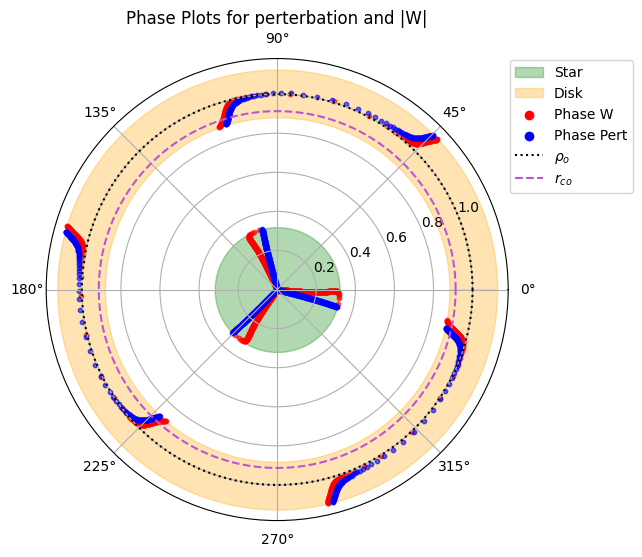

In [9]:
def Phase_Plot(target_folder, m_val, save_graph, view_graph):
    # column names from fort.** files (ref linstar.f)
    col_name_pert_phase =['phase5','rnorm(j)','ph180','ph90','ph270']
    col_name_W_phase = ['wphase','rnorm(j)','wph180','wph90','wph270']

    # import dataframes
    phase_pert_df = pd.read_csv(target_folder / "fort.53", names=col_name_pert_phase, header=None, sep='\s+')
    phase_W_df = pd.read_csv(target_folder / "fort.63", names=col_name_W_phase, header=None, sep='\s+')
    
    # Keep only the first two columns
    phase_pert_df = phase_pert_df[['rnorm(j)', 'phase5']]
    phase_W_df = phase_W_df[['rnorm(j)', 'wphase']]

    # Add additional phase shifts dependant on m_value > 1
    if m_val > 1:
        for i in range(m_val-1):
            shift_val = 360/m_val
            phase_pert_df[f'phase_shift_pert_{i+1}'] = phase_pert_df['phase5'] + (shift_val * (i+1))
            phase_W_df[f'phase_shift_W_{i+1}'] = phase_W_df['wphase'] + (shift_val * (i+1))
        
    # Graphing Phases
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'polar'})  # Create polar figure

    # Import Fort.50 details for plotting values
    df_50 = Fort_50_Import(target_folder=target_folder, Transpose=True)
    theta = np.linspace(0, 2*np.pi, 300)  # Full circle in radians

    # Add shading for star and torus
    shade = 0.3
    r_star = df_50.loc[df_50.index[0], "rstar/ro"]
    ax.fill_between(theta, 0, float(r_star.strip()), color='green', alpha=shade, label='Star')
    r_minus = df_50.loc[df_50.index[0], "r-/ro"]
    r_plus = df_50.loc[df_50.index[0], "r+/ro"]
    ax.fill_between(theta, float(r_minus.strip()), float(r_plus.strip()), color='orange', alpha=shade, label='Disk')

    # Add a single point for the legend
    ax.scatter([], [], color='red', label="Phase W")
    ax.scatter([], [], color='blue', label="Phase Pert")

    # Plot rho_o
    r = np.ones_like(theta)  # Constant radius at 1
    ax.plot(theta, r, color='black', label=r"$\rho_{o}$", linestyle=":")  # Dashed black circle

    # Plot R_co
    r_star = df_50.loc[df_50.index[0], "Rco/ro"]
    r_star = np.full_like(theta, r_star)
    ax.plot(theta, r_star, color='mediumorchid', label=r"$r_{co}$", linestyle="--")  # Dashed black circle

    # # Plot hard boundary lines
    # for boundary in ["rstar/ro", "r-/ro", "r+/ro"]:
    #     value = df_50.loc[df_50.index[0], boundary]  # Assuming row index is 0
    #     plot_value = np.full(len(theta), float(value.strip()))
    #     ax.plot(theta, plot_value, color='dimgrey', label=None)

    # Loop for actual data points (without labels)
    S= 10
    for col in phase_W_df.columns:
        if col != 'rnorm(j)':
            phase_W_df[col] = np.radians(phase_W_df[col])
            ax.scatter(phase_W_df[col], phase_W_df['rnorm(j)'], alpha=0.6, s=S, color='red', label=None)

    for col in phase_pert_df.columns:
        if col != 'rnorm(j)':
            phase_pert_df[col] = np.radians(phase_pert_df[col])
            ax.scatter(phase_pert_df[col], phase_pert_df['rnorm(j)'], alpha=0.6, s=S, color='blue', label=None)

    # # Adding labels and title
    # plt.xlabel('MIRP')
    # plt.ylabel(r'log($\omega$ Amplitude)')
    
    plt.title('Phase Plots for perterbation and |W|')

    # Displaying the legend outside of the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.1)

        # Save the figure before displaying
    if save_graph:
        save_path = target_folder / f"Phase_Plots_{target_folder.name}.png"
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    # Show the plot
    if view_graph:
        plt.show()
    
    plt.close()
    return(phase_pert_df, phase_W_df)

def Deploy_Phase_Plot(view_graph, save_graph):
    # Path for models to be plotted (settled models only)
    settled_models_path = Path("..", "Data_Galactic_Formation", "Models", "Settled_Models").resolve()

    # For loop that deploys plotting the phase of the perterbation and W
    for target_folder in settled_models_path.iterdir():
        # Verify only directories are targeted
        if not target_folder.is_dir():
            continue  # Skip if not a directory

        # Verify target model contains required files fort.22 & fort.23
        if not (target_folder / "fort.53").exists() or not (target_folder / "fort.63").exists():
            print(f"Warning: {target_folder.name} is missing fort.53 or fort.63")
            continue  # Skip this folder if fort.22 or fort.23 is missing
      
        # Assuming target_folder is a Path object
        target_name = target_folder.name

        js_value = re.search(r"js(\d+)", target_name)
        jin_value = re.search(r"jin(\d+)", target_name)
        jout_value = re.search(r"jout(\d+)", target_name)
        m_value = re.search(r"m(\d+)", target_name)


        js_number = int(js_value.group(1)) if js_value else None
        jin_number = int(jin_value.group(1)) if jin_value else None
        jout_number = int(jout_value.group(1)) if jout_value else None
        m_number = int(m_value.group(1)) if m_value else None

        print(f"model: {target_folder.name},  m: {m_number}, js: {js_number}, jin: {jin_number}, jout: {jout_number}")

        # Deploy and Sort models based on Global Growth Rate test results
        Plot_of_Phases = Phase_Plot(target_folder, m_val=m_number, save_graph=save_graph, view_graph=view_graph)
        
        # return(Plot_of_Phases)

# # Test Deployt_Phase_Plot for all settled
Deploy_Phase_Plot(view_graph=True, save_graph=False)